In [1]:
import torch
if torch.cuda.is_available() == True:
    device = 'cuda:0'
    print('GPU 사용 가능')
else:
    device = 'cpu'
    print('GPU 사용 불가')

GPU 사용 가능


In [2]:
# 학습 추이 기록

def init_log():
    plt.rc('font', size = 10)
    # 모든 log를 초기화
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록용
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록용
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # 리스트 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

from IPython.display import clear_output
def print_log():
    # 학습 추이 출력

    # 소숫점 3자리 수까지 조절
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = f'Epoch: {last(iter_log):3} | T_Loss {train_loss:5} | T_acc {train_acc:5} | V_Loss {val_loss:5} | V_acc. {val_acc:5} | Time {time_spent:5}'

    log_stack.append(log_str)

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99) # 그래프 사이즈 설정
    hist_fig.patch.set_facecolor('white') # 그래프 배경색 설정
    
    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')
    
    # Acc. Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train Acc.', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid Acc.', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')
    
    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line # 위에서 선언한 plt정보들 통합
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines]) # 순서대로 그려주기
    loss_axis.grid() # 격자 설정
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()
    
    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))): # 반대로 sort 시켜서 출력
        print(log_stack[idx])

In [3]:
import numpy as np
import random

# train dataset 집어넣기
dataset = []

def load_dataset(name):
    forehand = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Forehand_sampling_train_dataset.npy')
    backhand = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Backhand_sampling_train_dataset.npy')
    backslice = np.load(f'../variable_dataset/training_data/{name}/{name}_B_BackSlice_sampling_train_dataset.npy')
    forevolley = np.load(f'../variable_dataset/training_data/{name}/{name}_B_ForeVolley_sampling_train_dataset.npy')
    backvolley = np.load(f'../variable_dataset/training_data/{name}/{name}_B_BackVolley_sampling_train_dataset.npy')
    smash = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Smash_sampling_train_dataset.npy')
    serve = np.load(f'../variable_dataset/training_data/{name}/{name}_B_Serve_sampling_train_dataset.npy')

    for i in forehand:
        dataset.append({'key':0, 'value':i})
    for i in backhand:
        dataset.append({'key':1, 'value':i})
    for i in backslice:
        dataset.append({'key':2, 'value':i})
    for i in forevolley:
        dataset.append({'key':3, 'value':i})
    for i in backvolley:
        dataset.append({'key':4, 'value':i})
    for i in smash:
        dataset.append({'key':5, 'value':i})
    for i in serve:
        dataset.append({'key':6, 'value':i})

load_dataset('Federer')
load_dataset('Nadal_inv')
load_dataset('Djokovic')
load_dataset('Sinner')
load_dataset('Tsitsipas')
load_dataset('Zverev')
load_dataset('Murray')
load_dataset('Alcaraz')
load_dataset('Rune')
load_dataset('Shapovalov_inv')

random.shuffle(dataset)
print(len(dataset))

8529


In [4]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader # Pytorch에서 데이터를 불러오고, 전처리하는 클래스

class MyDataset(Dataset):
    def __init__(self, seq_data):
        self.X = []
        self.y = []
        for dic in seq_data:
            self.X.append(dic['value'])
            self.y.append(dic['key'])

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]
        return torch.Tensor(np.array(data)), torch.tensor(np.array(int(label)))

    def __len__(self):
            return len(self.X)

In [5]:
split_ratio = [0.8, 0.2]
train_len = round(len(dataset) * split_ratio[0])
val_len = round(len(dataset) * split_ratio[1])
print(f'{train_len}, {val_len}')

6823, 1706


In [6]:
from torch.utils.data import random_split
train_dataset = MyDataset(dataset)
train_data, valid_data = random_split(train_dataset, [train_len, val_len])

train_loader = DataLoader(train_data, batch_size=16)
val_loader = DataLoader(valid_data, batch_size=16)

In [7]:
class LSTM_model(nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        self.lstm1 = nn.LSTM(input_size=100, hidden_size = 172, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=172, hidden_size = 256, num_layers=1, batch_first=True)
        self.lstm3 = nn.LSTM(input_size=256, hidden_size = 512, num_layers=1, batch_first=True)
        self.lstm4 = nn.LSTM(input_size=512, hidden_size = 256, num_layers=1, batch_first=True)
        self.lstm5 = nn.LSTM(input_size=256, hidden_size = 128, num_layers=1, batch_first=True)
        self.lstm6 = nn.LSTM(input_size=128, hidden_size = 64, num_layers=1, batch_first=True)
        self.lstm7 = nn.LSTM(input_size=64, hidden_size = 32, num_layers=1, batch_first=True)
        self.lstm8 = nn.LSTM(input_size=32, hidden_size = 16, num_layers=1, batch_first=True)
        self.fc = nn.Linear(16, 7)
        self.dropout1 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.3)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x, _ = self.lstm3(x)
        x = self.dropout1(x)
        x, _ = self.lstm4(x)
        x, _ = self.lstm5(x)
        x, _ = self.lstm6(x)
        x = self.dropout2(x)
        x, _ = self.lstm7(x)
        x, _ = self.lstm8(x)
        x = self.fc(x[:,-1,:])
        return x

In [8]:
# 모델 초기화
import matplotlib.pyplot as plt
from torch.optim import Adam
def init_model():
    plt.rc('font', size = 10)
    global model, loss_fn, optim
    model = LSTM_model().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(model.parameters(), lr=0.0001)

# epoch count 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

In [9]:
import gc
from torch.cuda import memory_allocated, empty_cache
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
import numpy as np
from tqdm import tqdm
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘(for 문을 나오면 1 epoch 완료)
    for _data, _label in tqdm(data_loader, desc='Training'):
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device) # Tensor에서 64-bit integer 사용하면 LongTensor

        # 1. Feed-forward
        if mode == 'train':
            model.train()
        else:
            # 학습때만 쓰이는 Dropout, Batch Mormalization을 미사용
            model.eval()
    
        result = model(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로 
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출 / 첫번째 인자는 값을 두번째 인자는 index를 돌려준다.
    
        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록
    
        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기로 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문 나가면 epoch 카운터 += 1
    
        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # Label == GT(실제 환경 데이터)인 개수
        acc_partial = acc_partial / len(label) # (TP / (TP + TN)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Accuracy 기록

    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    # loss와 acc의 평균값 for 학습 추이 그래프, 모든 GT와 Label 값 for 컨퓨전 행렬
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [10]:
# Training Initialization
init_model()
init_epoch()
init_log()
maximum_epoch = 1000

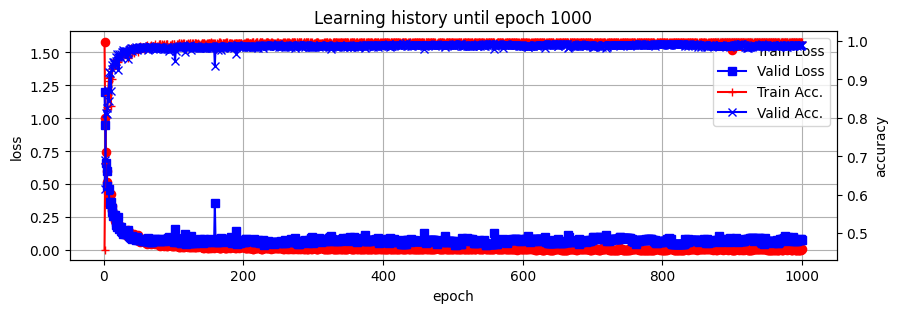

Epoch: 1000 | T_Loss 0.009 | T_acc 0.997 | V_Loss 0.075 | V_acc. 0.991 | Time 3.265
Epoch: 999 | T_Loss 0.007 | T_acc 0.997 | V_Loss 0.084 | V_acc. 0.989 | Time 3.263
Epoch: 998 | T_Loss 0.003 | T_acc 0.998 | V_Loss 0.076 | V_acc. 0.987 | Time 3.274
Epoch: 997 | T_Loss 0.003 | T_acc 0.998 | V_Loss 0.081 | V_acc. 0.988 | Time  3.26
Epoch: 996 | T_Loss 0.003 | T_acc 0.998 | V_Loss 0.079 | V_acc. 0.989 | Time 3.263
Epoch: 995 | T_Loss 0.003 | T_acc 0.998 | V_Loss 0.074 | V_acc. 0.989 | Time 3.498
Epoch: 994 | T_Loss 0.003 | T_acc 0.998 | V_Loss 0.072 | V_acc. 0.989 | Time 3.266
Epoch: 993 | T_Loss 0.004 | T_acc 0.998 | V_Loss  0.07 | V_acc. 0.988 | Time 3.248
Epoch: 992 | T_Loss 0.003 | T_acc 0.998 | V_Loss 0.075 | V_acc. 0.989 | Time 3.255
Epoch: 991 | T_Loss 0.004 | T_acc 0.998 | V_Loss 0.072 | V_acc. 0.989 | Time 3.249
Epoch: 990 | T_Loss 0.004 | T_acc 0.998 | V_Loss  0.07 | V_acc. 0.989 | Time 3.245
Epoch: 989 | T_Loss 0.007 | T_acc 0.997 | V_Loss 0.068 | V_acc. 0.989 | Time 3.255
Epo

In [11]:
# Training Iteration
import time
loss_result = []
while epoch_not_finished():
    start_time = time.time()
    tloss, tacc = epoch(train_loader, mode = 'train')
    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)
    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)
    print_log()
    test_acc = test_data()
    loss_result.append(f'tloss : {tloss:.5} | tacc : {tacc:.5} | vloss : {vloss:.5} | vacc : {vacc:.5} | test : {test_acc}')
    if test_acc < 20:
        torch.save(model.state_dict(), f'./model_info/classification_model_{test_acc}_{tloss:.5}_{tacc:.5}_{vloss:.5}_{vacc:.5}')
print('\n Training completed!')

In [12]:
# 모델 저장하기
torch.save(model.state_dict(), f'./model_info/classification_model_{tloss:.5}_{tacc:.5}_{vloss:.5}_{vacc:.5}')

In [ ]:
cnt = 0
with open("classification_train_result.txt", "w") as f:
    for i in loss_result:
        cnt += 1
        f.write(str(cnt))
        f.write(" ")
        f.write(str(i))
        f.write(" \n")

<b>Test

In [11]:
model.load_state_dict(torch.load('./classification_model_0.0044723_0.9978_0.047615_0.99241', map_location=device))

<All keys matched successfully>

In [12]:
test_forehand_dataset = []
test_backhand_dataset = []
test_backslice_dataset = []
test_forevolley_dataset = []
test_backvolley_dataset = []
test_smash_dataset = []
test_serve_dataset = []

def load_test_dataset(name):
    forehand = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Forehand_sampling_test_dataset.npy')
    backhand = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Backhand_sampling_test_dataset.npy')
    backslice = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_BackSlice_sampling_test_dataset.npy')
    forevolley = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_ForeVolley_sampling_test_dataset.npy')
    backvolley = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_BackVolley_sampling_test_dataset.npy')
    smash = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Smash_sampling_test_dataset.npy')
    serve = np.load(f'../variable_dataset/testing_data/{name}/{name}_B_Serve_sampling_test_dataset.npy')

    for i in forehand:
        test_forehand_dataset.append({'key':0, 'value':i})
    for i in backhand:
        test_backhand_dataset.append({'key':1, 'value':i})
    for i in backslice:
        test_backslice_dataset.append({'key':2, 'value':i})
    for i in forevolley:
        test_forevolley_dataset.append({'key':3, 'value':i})
    for i in backvolley:
        test_backvolley_dataset.append({'key':4, 'value':i})
    for i in smash:
        test_smash_dataset.append({'key':5, 'value':i})
    for i in serve:
        test_serve_dataset.append({'key':6, 'value':i})

load_test_dataset('Federer')
load_test_dataset('Nadal_inv')
load_test_dataset('Sinner')
load_test_dataset('Tsitsipas')
load_test_dataset('Murray')
load_test_dataset('Shapovalov_inv')

test_dataset = test_forehand_dataset + test_backhand_dataset + test_backslice_dataset + test_forevolley_dataset + test_backvolley_dataset + test_smash_dataset + test_serve_dataset 
print(len(test_dataset))

test_dataset = MyDataset(test_dataset)
test_dataset = DataLoader(test_dataset)

1228


In [ ]:
def test_data():
    test_data_list = []
    model.eval()

    for data, label in tqdm(test_dataset):
        data = data.to(device)
        with torch.no_grad():
            classification_result = model(data)
            classification_result = F.softmax(classification_result, dim=1)
            out_result, out = torch.max(classification_result, 1)
    
            if out.item() == 0: 
                test_data_list.append('Forehand')
            elif out.item() == 1: 
                test_data_list.append('Backhand')
            elif out.item() == 2: 
                test_data_list.append('Backslice')
            elif out.item() == 3: 
                test_data_list.append('ForeVolley')
            elif out.item() == 4: 
                test_data_list.append('BackVolley')
            elif out.item() == 5: 
                test_data_list.append('Smash')
            elif out.item() == 6: 
                test_data_list.append('Serve')

    cnt = 0
    check = 0
    
    for i in test_data_list:
        cnt += 1
        if cnt <= len(test_forehand_dataset):
            if i != 'Forehand':
                check += 1
                print('Forehand', i)
        elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset):
            if i != 'Backhand':
                check += 1
                print('Backhand', i)
        elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset):
            if i != 'Backslice':
                check += 1
                print('Backslice', i)
        elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset) + len(test_forevolley_dataset):
            if i != 'ForeVolley':
                check += 1
                print('ForeVolley', i)
        elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset) + len(test_forevolley_dataset) + len(test_backvolley_dataset):
            if i != 'BackVolley':
                check += 1
                print('BackVolley', i)
        elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset) + len(test_forevolley_dataset) + len(test_backvolley_dataset) + len(test_smash_dataset):
            if i != 'Smash':
                check += 1
                print('Smash', i)
        elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset) + len(test_forevolley_dataset) + len(test_backvolley_dataset) + len(test_smash_dataset) + len(test_serve_dataset):
            if i != 'Serve':
                check += 1
                print('Serve', i)

    return check

In [13]:
# Classification
test_data_list = []
model.eval()

for data, label in tqdm(test_dataset):
    data = data.to(device)
    with torch.no_grad():
        classification_result = model(data)
        classification_result = F.softmax(classification_result, dim=1)
        out_result, out = torch.max(classification_result, 1)

        if out.item() == 0: 
            test_data_list.append('Forehand')
        elif out.item() == 1: 
            test_data_list.append('Backhand')
        elif out.item() == 2: 
            test_data_list.append('Backslice')
        elif out.item() == 3: 
            test_data_list.append('ForeVolley')
        elif out.item() == 4: 
            test_data_list.append('BackVolley')
        elif out.item() == 5: 
            test_data_list.append('Smash')
        elif out.item() == 6: 
            test_data_list.append('Serve')

100%|███████████████████████████████████████████████████████████████| 1228/1228 [00:08<00:00, 137.84it/s]


In [14]:
cnt = 0
check = 0

for i in test_data_list:
    cnt += 1
    if cnt <= len(test_forehand_dataset):
        if i != 'Forehand':
            check += 1
            print('Forehand', i)
    elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset):
        if i != 'Backhand':
            check += 1
            print('Backhand', i)
    elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset):
        if i != 'Backslice':
            check += 1
            print('Backslice', i)
    elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset) + len(test_forevolley_dataset):
        if i != 'ForeVolley':
            check += 1
            print('ForeVolley', i)
    elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset) + len(test_forevolley_dataset) + len(test_backvolley_dataset):
        if i != 'BackVolley':
            check += 1
            print('BackVolley', i)
    elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset) + len(test_forevolley_dataset) + len(test_backvolley_dataset) + len(test_smash_dataset):
        if i != 'Smash':
            check += 1
            print('Smash', i)
    elif cnt <= len(test_forehand_dataset) + len(test_backhand_dataset) + len(test_backslice_dataset) + len(test_forevolley_dataset) + len(test_backvolley_dataset) + len(test_smash_dataset) + len(test_serve_dataset):
        if i != 'Serve':
            check += 1
            print('Serve', i)

print(check)

Forehand Smash
Backhand BackVolley
Backslice Backhand
Backslice Backhand
Backslice Backhand
Backslice BackVolley
Backslice Backhand
Backslice BackVolley
Backslice Backhand
Backslice Backhand
Backslice BackVolley
Backslice Backhand
Backslice Backhand
Backslice Backhand
Backslice Backhand
Backslice Backhand
Backslice Backhand
Backslice Backhand
Backslice Backhand
ForeVolley Smash
BackVolley Backhand
21
